### Introduction


This project analyzes a loan default dataset and utilizes a weighted logistic regression model to predict defaults. Predicting defaults is important for lenders to manage financial risk and make informed lending decisions. We model the probability of default based on borrower characteristics and loan information, with model performance being evaluated using recall, precision, and F1-score.

In [111]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [90]:
loan_default = pd.read_csv("~/OneDrive/Desktop/loan_regression/Loan_Default.csv")
loan_default.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [91]:
loan_default.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


### Data Description

The following core variables were identified to eliminate variable redundancy and provide a balanced set of borrower and loan characteristics to help the model capture loan risk factors:

Explanatory Variables:

* loan_amount: Amount of money being borrowed.

* rate_of_interest: Interest rate of the loan.      

* term: Length of the loan in months.

* Credit_Score: Applicant's credit score.         

* LTV: Loan-to-value ratio, amount of a loan divided by the value of the asset being financed.        

* dtir1: Debt-to-income ratio, total monthly debt payments divided by gross monthly income.    

* business_or_commercial: Whether the loan is for business/commercial purposes.

Target Variable:

* Status: Whether or not the loan defaulted.

### Data Cleaning

The business_or_commercial feature indicates whether the loan is personal (nob/c) or business/commercial (b/c), and thus was converted into an indicator variable (1 = business/commercial, 0 = personal) for simplicity.

In [92]:
loan_default['business_or_commercial_ind'] = loan_default['business_or_commercial'].map({'b/c':1, 'nob/c':0})

The core features identified in the Data Description were selected and features outside the core set were removed.

In [93]:
loan_default = loan_default[['loan_amount', 'rate_of_interest', 'term', 'Credit_Score', 'LTV', 'dtir1', 'business_or_commercial_ind', 'Status']]
loan_default.head()

,loan_amount,rate_of_interest,term,Credit_Score,LTV,dtir1,business_or_commercial_ind,Status
0,116500,NaN,360.0,758,98.728814,45.0,0,1
1,206500,NaN,360.0,552,NaN,NaN,1,1
2,406500,4.56,360.0,834,80.019685,46.0,0,0
3,456500,4.25,360.0,587,69.376900,42.0,0,0
4,696500,4.00,360.0,602,91.886544,39.0,0,0


In [94]:
loan_default.isnull().sum()

loan_amount                       0
rate_of_interest              36439
term                             41
Credit_Score                      0
LTV                           15098
dtir1                         24121
business_or_commercial_ind        0
Status                            0
dtype: int64

Variables with missing values (rate_of_interest, Credit_Score, LTV, dtir1) were imputed using the median to limit the influence of outliers.

Rows with missing values in term were dropped since the proportion of affected observations was negligible.

In [95]:
for col in ['rate_of_interest', 'Credit_Score', 'LTV', 'dtir1']:
    loan_default[col] = loan_default[col].fillna(loan_default[col].median())

loan_default = loan_default.dropna(subset=['term'])

In [96]:
loan_default.isnull().sum()

loan_amount                   0
rate_of_interest              0
term                          0
Credit_Score                  0
LTV                           0
dtir1                         0
business_or_commercial_ind    0
Status                        0
dtype: int64

Inspection of the LTV variable revealed extreme outliers. Of the 148,000 observations, only six had a LTV greater than 300. Of these six, all were greater than 2000. Thus, these extreme outliers were removed to preserve the integrity of the regression analysis.

In [97]:
loan_default[loan_default['LTV'] > 300]

,loan_amount,rate_of_interest,term,Credit_Score,LTV,dtir1,business_or_commercial_ind,Status
16951,626500,3.875,360.0,522,7831.25,39.0,1,0
46287,236500,3.990,360.0,724,2956.25,39.0,1,1
47807,416500,3.500,360.0,571,5206.25,39.0,1,0
55286,536500,3.750,360.0,591,6706.25,39.0,1,0
65238,376500,3.750,360.0,691,4706.25,39.0,1,0
123343,186500,3.990,360.0,826,2331.25,39.0,1,0


In [98]:
loan_default = loan_default[loan_default['LTV'] <= 300]

### Exploratory Data Analysis

In [99]:
loan_default.describe()

,loan_amount,rate_of_interest,term,Credit_Score,LTV,dtir1,business_or_commercial_ind,Status
count,1.486230e+05,148623.000000,148623.000000,148623.000000,148623.000000,148623.000000,148623.000000,148623.000000
mean,3.311585e+05,4.031877,335.135578,699.795792,72.796364,37.938697,0.139655,0.246415
std,1.839104e+05,0.488390,58.410049,115.876650,17.969276,9.663808,0.346630,0.430925
min,1.650000e+04,0.000000,96.000000,500.000000,0.967478,5.000000,0.000000,0.000000
25%,1.965000e+05,3.750000,360.000000,599.000000,63.297872,33.000000,0.000000,0.000000
50%,2.965000e+05,3.990000,360.000000,699.000000,75.135870,39.000000,0.000000,0.000000
75%,4.365000e+05,4.250000,360.000000,800.000000,84.722222,44.000000,0.000000,0.000000
max,3.576500e+06,8.000000,360.000000,900.000000,263.541667,61.000000,1.000000,1.000000


#### Loan Amount

The mean loan amount is $331,000, while the median is $296,000. The mean exceeds the median, indicating right skewness. Also, a high maximum ($3.58 million) relative to the upper quartile ($436,000) indicates high-value outliers. Viewing the data as a histogram confirms this.

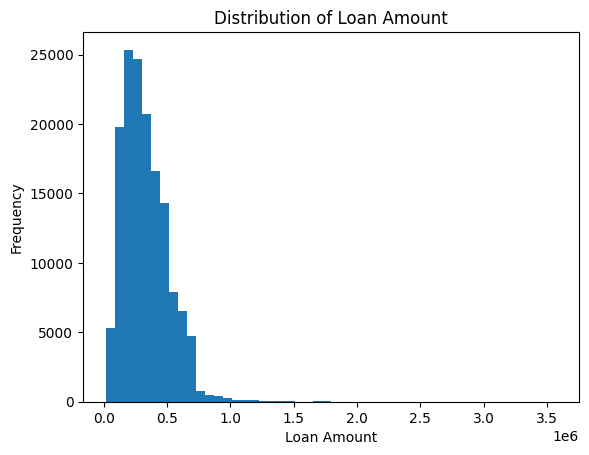

In [100]:
plt.hist(loan_default['loan_amount'], bins = 50)
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amount')
plt.show()

#### Interest Rate

The mean and median interest rates are both approximately 4%, indicating there is minimal skew and that the distribution is roughly symmetrical. The histogram of the data shows that the majority of data points are concentrated near the mean.

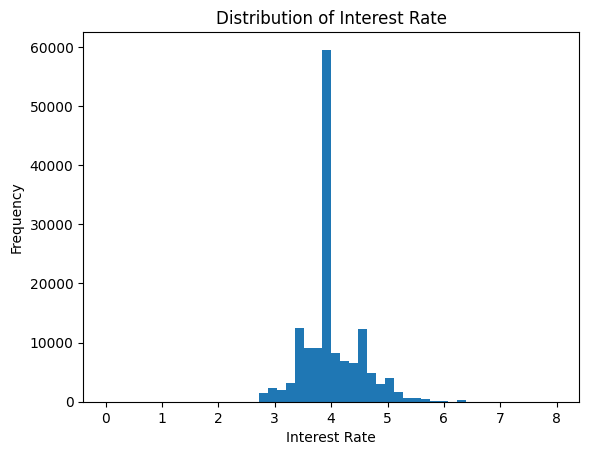

In [101]:
plt.hist(loan_default['rate_of_interest'], bins = 50)
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Interest Rate')
plt.show()

#### Term Length

The mean term length is 335 months, while the median is 360 months, indicating a left skew. The maximum of the term lengths is also 360 months, showing that most of the recorded term lengths were 360 months. Visualizing the data as a histogram confirms these observations.

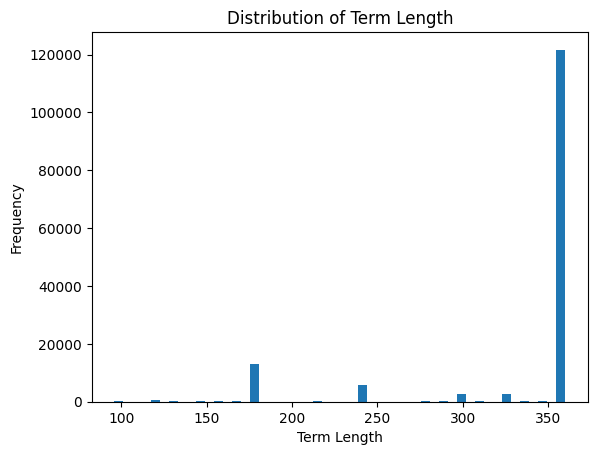

In [102]:
plt.hist(loan_default['term'], bins = 50)
plt.xlabel('Term Length')
plt.ylabel('Frequency')
plt.title('Distribution of Term Length')
plt.show()

#### Credit Score

The mean and median credit scores are both approximately 700, signifying a roughly symmetric distribution of credit scores. Here, the histogram provides an interesting result, that the distribution is approximately evenly distributed between 500 and 900.

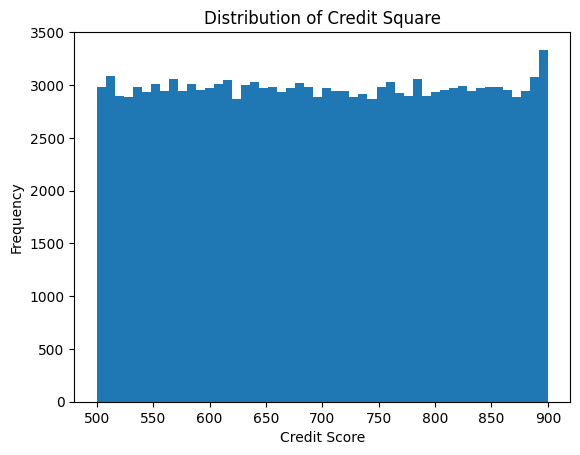

In [103]:
plt.hist(loan_default['Credit_Score'], bins = 50)
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Square')
plt.show()

#### Loan to Value Ratio

The mean LTV is approximately 73%, with a median of 75%, indicating a slight left skew and data concentrated in a relatively high LTV range. Inspection of the histogram of the data shows a left tail, suggesting very few loans have low LTVs.

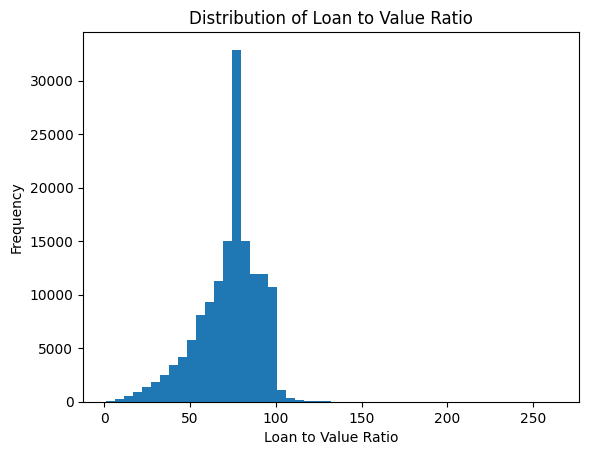

In [104]:
plt.hist(loan_default['LTV'], bins = 50)
plt.xlabel('Loan to Value Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Loan to Value Ratio')
plt.show()

#### Debt-to-Income Ratio

The debt-to-income ratio has a mean of approximately 38% and a median of 39%, suggesting a roughly symmetric distribution. Most borrowers fall between 33% and 44%. The histogram confirms that the distribution is moderately concentrated about the median, with a large spike at the median.

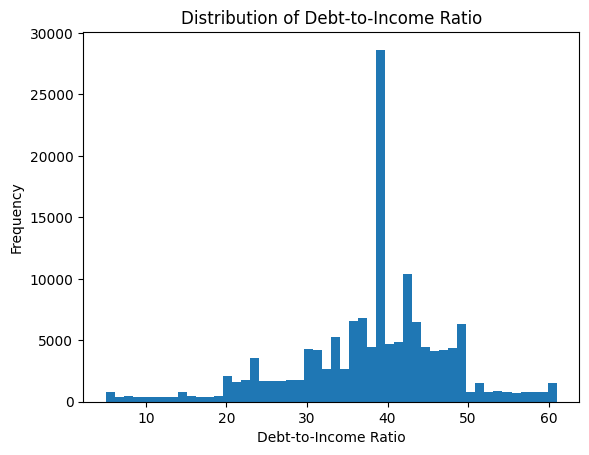

In [105]:
plt.hist(loan_default['dtir1'], bins = 50)
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Debt-to-Income Ratio')
plt.show()

#### Business or Commercial

Approximately 14% of the loans are for business or commercial purposes, while the remaining 86% are personal.

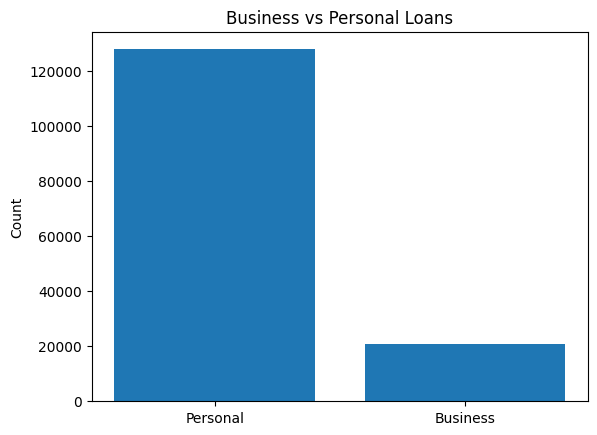

In [106]:

plt.bar(['Personal', 'Business'], loan_default['business_or_commercial_ind'].value_counts())
plt.ylabel('Count')
plt.title('Business vs Personal Loans')
plt.show()

#### Status

Approximately 25% of the loans defaulted, while the remaining 75% did not.

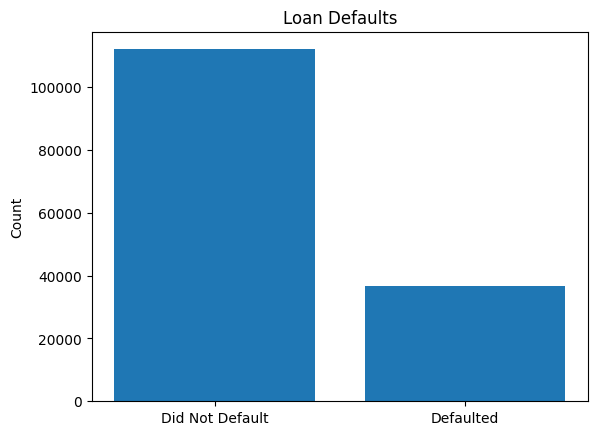

In [107]:
plt.bar(['Did Not Default', 'Defaulted'], loan_default['Status'].value_counts())
plt.ylabel('Count')
plt.title('Loan Defaults')
plt.show()

#### Correlations

Most of the variables are relatively uncorrelated, with all correlation coefficients falling between 0 and 0.25. This suggests limited linear association between features and reduces concerns of multicollinearity.

In [108]:
loan_default.corr()

,loan_amount,rate_of_interest,term,Credit_Score,LTV,dtir1,business_or_commercial_ind,Status
loan_amount,1.000000,-0.122796,0.174472,0.004437,0.068920,0.014885,-0.162677,-0.036748
rate_of_interest,-0.122796,1.000000,0.182874,-0.001377,0.000893,0.029882,-0.046450,-0.046727
term,0.174472,0.182874,1.000000,-0.003143,0.208612,0.106361,0.093342,-0.000237
Credit_Score,0.004437,-0.001377,-0.003143,1.000000,-0.003120,-0.000322,-0.000758,0.003957
LTV,0.068920,0.000893,0.208612,-0.003120,1.000000,0.158386,0.247770,0.093672
dtir1,0.014885,0.029882,0.106361,-0.000322,0.158386,1.000000,0.156500,0.082368
business_or_commercial_ind,-0.162677,-0.046450,0.093342,-0.000758,0.247770,0.156500,1.000000,0.092631
Status,-0.036748,-0.046727,-0.000237,0.003957,0.093672,0.082368,0.092631,1.000000


### Modeling and Interpretation

The data was split into testing and training sets, stratifying status to ensure the proportion of defaulting loans was the same in estimation and evaluation. The testing and training sets were split into the explanatory and target variables, before fitting a logistic regression model to the training set. A baseline logistic regression model was compared to a weighted one, settling on the weighted one for higher recall at a cost of overall accuracy.

In [109]:
train, test = train_test_split(loan_default, test_size=0.2, stratify=loan_default['Status'])

x_train = train[['loan_amount', 'rate_of_interest', 'term', 'Credit_Score', 'LTV', 'dtir1', 'business_or_commercial_ind']]
y_train = train['Status']

x_test = test[['loan_amount', 'rate_of_interest', 'term', 'Credit_Score', 'LTV', 'dtir1', 'business_or_commercial_ind']]
y_test = test['Status']

X1_train = sm.add_constant(x_train)
X1_test = sm.add_constant(x_test)

model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
model.fit(X1_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

The regression model was then evaluated on the testing set, and the confusion matrix below shows the results.

In [113]:
y_pred = model.predict_proba(X1_test)[:, 1]
y_pred = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[11487 10913]
 [ 3006  4319]]


In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.51      0.62     22400
           1       0.28      0.59      0.38      7325

    accuracy                           0.53     29725
   macro avg       0.54      0.55      0.50     29725
weighted avg       0.67      0.53      0.56     29725



The weighted logistic regression achieved a recall of 0.59 for defaulting loans, meaning 59% of actual defaults were correctly identified. This improves the model's ability to detect high-risk borrowers. However, precision for the default class is 0.28, indicating that many predicted defaults are false positives. This reflects the tradeoff introduced by class weighting: improving recall comes at the expense of precision and overall accuracy (0.53). Because failing to identify a defaulting borrower is more costly than incorrectly flagging a non-defaulting one, prioritizing recall is arguably economically justified in this context.

### Conclusion

In this project, we utilized a weighted logistic regression model to predict loan defaults, achieving a recall of 0.59 for defaulting loans. While the precision is lower at 0.28, it is important to note that falsely flagging loan defaults is less costly than failing to identify them. Thus, recall is prioritized over overall precision and accuracy in this setting. Although the model provides a solid baseline, future work could focus more on interaction terms and alternative classification methods to further improve the balance of recall and precision.